In [32]:
import os
import random
import re
import sys
from datetime import datetime
from random import sample

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from sklearn import preprocessing
from sklearn.metrics import log_loss, mean_squared_error
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable
from torch.distributions.kl import kl_divergence
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader, Dataset

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torchvision.utils import save_image

In [33]:
path = "/Users/M283455/VAE_prject/scripts/"
sys.path.insert(0, path)

In [34]:
import VAE_tybalt
from VAE_tybalt import VAE

In [35]:
model = VAE(input_dim=5000, hidden_dim=[100], z_dim=100)

In [36]:
model.load_state_dict(torch.load("../output/models/vae_weights.pth"))

<All keys matched successfully>

In [37]:
tcga_tybalt_file_location = (
    "../../VAE_prject_data/raw/pancan_scaled_zeroone_rnaseq.tsv.gz"
)
rnaseq_df = pd.read_table(tcga_tybalt_file_location)
rnaseq_df.drop(columns=rnaseq_df.columns[0], axis=1, inplace=True)
rnaseq_df = rnaseq_df.dropna()

In [38]:
model.load_state_dict(torch.load("../output/models/vae_weights.pth"))

<All keys matched successfully>

In [39]:
# How well does the model reconstruct the input RNAseq data
def VAE_latent_out(df):
    mu = model.forward(torch.tensor(df.values, dtype=torch.float32))[2]
    sigma = model.forward(torch.tensor(df.values, dtype=torch.float32))[3]

    column_names = [str(i) for i in range(100)]

    mu = pd.DataFrame(mu.detach().numpy(), columns=column_names)
    sigma = pd.DataFrame(sigma.detach().numpy(), columns=column_names)

    return mu, sigma

In [40]:
latent_mu, latent_sigma = VAE_latent_out(rnaseq_df)

In [41]:
import pandas as pd
import umap.umap_ as umap

# Assuming you have a pandas DataFrame named 'latent_mu' with the data

# Extract the features from the DataFrame
features = latent_mu.iloc[:, 0:-1].values

# Perform UMAP dimensionality reduction
umap_result = umap.UMAP().fit_transform(features)

# Create a new DataFrame with UMAP coordinates
umap_df = pd.DataFrame(umap_result, columns=["UMAP1", "UMAP2"])

# Concatenate the UMAP DataFrame with the original DataFrame
result_df = pd.concat([latent_mu, umap_df], axis=1)

In [42]:
result_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,UMAP1,UMAP2
0,-0.412649,0.710175,-0.795810,0.887554,-1.259630,-0.847377,-0.060489,-0.390947,-0.617078,-0.224537,...,-0.796305,-0.167217,-0.399551,-0.202910,0.457631,-0.641116,0.087899,-0.780150,13.897029,16.326591
1,-0.245373,0.819964,-0.109069,0.217647,-0.714195,-0.172589,-0.555804,-0.944640,-0.459089,-0.684127,...,-1.197324,0.372887,-0.260377,0.153839,0.438741,-1.061390,-0.179697,-0.900864,14.185329,15.961164
2,-0.603684,0.487100,-0.804239,0.921643,-0.882696,-0.606947,0.374666,-0.536518,-0.405642,-0.688019,...,-1.005515,-0.384390,-0.408506,-0.529698,-0.121677,-0.461944,-0.349346,-0.464267,13.069489,16.371048


In [43]:
embedded_dataframe = result_df.copy()

In [44]:
tcga_tybalt_file_location = (
    "../../VAE_prject_data/raw/pancan_scaled_zeroone_rnaseq.tsv.gz"
)
df = pd.read_table(tcga_tybalt_file_location)
# df.drop(columns=df.columns[0], axis=1, inplace=True)

In [45]:
embedded_dataframe["id"] = df["Unnamed: 0"]

In [46]:
embedded_dataframe["id"]
# print(embedded_dataframe['id'].str.len().min())

0        TCGA-02-0047-01
1        TCGA-02-0055-01
2        TCGA-02-2483-01
3        TCGA-02-2485-01
4        TCGA-02-2486-01
              ...       
10454    TCGA-ZS-A9CG-01
10455    TCGA-ZT-A8OM-01
10456    TCGA-ZU-A8S4-01
10457    TCGA-ZU-A8S4-11
10458    TCGA-ZX-AA5X-01
Name: id, Length: 10459, dtype: object

In [47]:
# clinical data
clincal_file = "../../VAE_prject_data/raw/clinical_data.tsv"
clincal_df = pd.read_table(clincal_file)

In [48]:
clincal_df["id"] = clincal_df.portion_id.str[: embedded_dataframe["id"].str.len().min()]

In [49]:
clincal_df.shape

(11284, 18)

In [50]:
embedded_dataframe.shape

(10459, 103)

In [51]:
merged_latent_clinical_df = pd.merge(
    clincal_df, embedded_dataframe, on="id", how="inner"
)

In [52]:
merged_latent_clinical_df.head(3)

,sample_id,ethnicity,year_of_diagnosis,gender,race,organ,percent_tumor_nuclei,age_at_diagnosis,sample_type,analysis_center,...,92,93,94,95,96,97,98,99,UMAP1,UMAP2
0,TCGA-CD-8534,not hispanic or latino,2011,male,asian,Stomach,85.0,41.0,Primary Tumor,BCGSC,...,-1.217980,0.612282,-0.695295,-0.843861,-0.171759,0.241048,-0.611222,-0.373460,-0.335435,6.021543
1,TCGA-ER-A19A,not hispanic or latino,2006,male,white,Skin,85.0,79.0,Metastatic,UNC,...,-0.383564,0.383218,0.691871,0.204385,0.653908,0.095414,0.080750,-0.675321,7.622840,4.468493
2,TCGA-C5-A1M8,not hispanic or latino,2001,female,white,Cervix,85.0,43.0,Primary Tumor,UNC,...,1.256918,-2.735865,0.569573,-0.409968,-0.565986,0.200135,-1.258146,0.696444,5.362579,3.224942


In [53]:
clincal_df.columns

Index(['sample_id', 'ethnicity', 'year_of_diagnosis', 'gender', 'race',
       'organ', 'percent_tumor_nuclei', 'age_at_diagnosis', 'sample_type',
       'analysis_center', 'vital_status', 'acronym', 'portion_id', 'disease',
       'drug', 'platform', 'stage', 'id'],
      dtype='object')

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

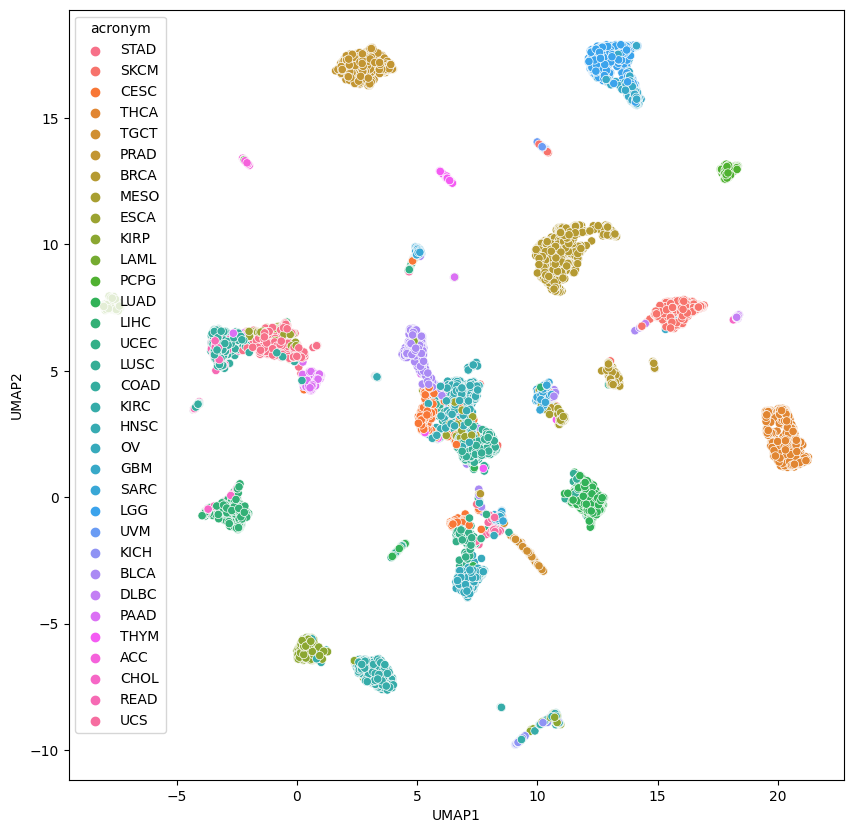

In [54]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=merged_latent_clinical_df, x="UMAP1", y="UMAP2", hue="acronym")

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

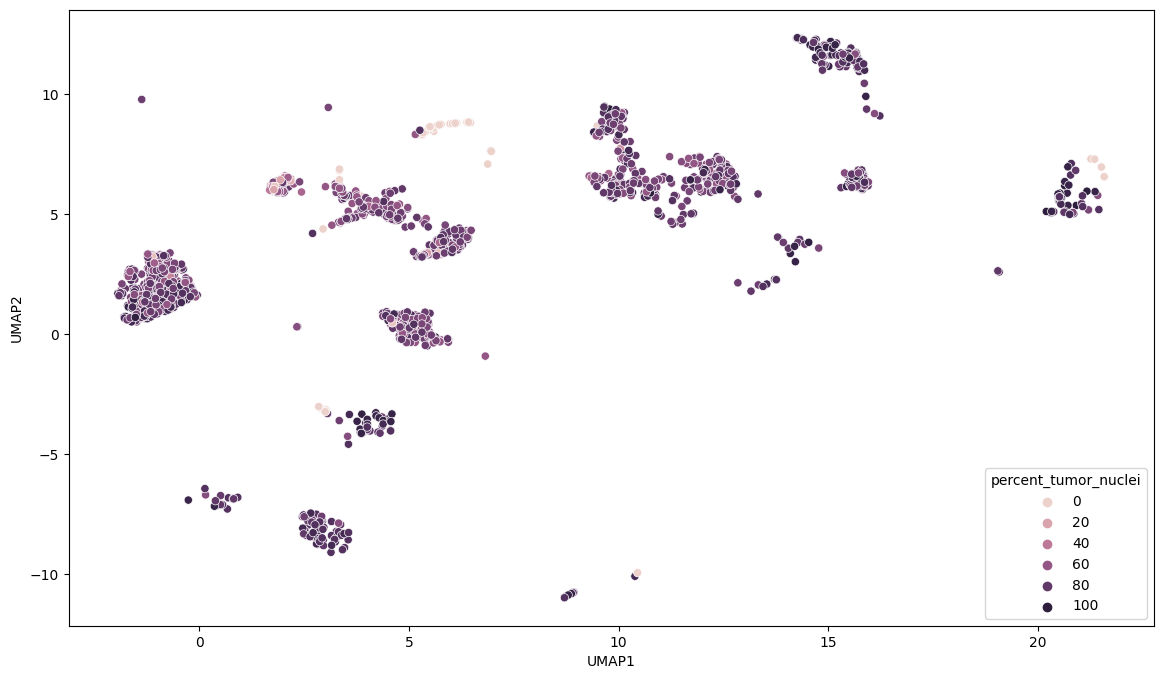

In [101]:
plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=merged_latent_clinical_df, x="UMAP1", y="UMAP2", hue="percent_tumor_nuclei"
)

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

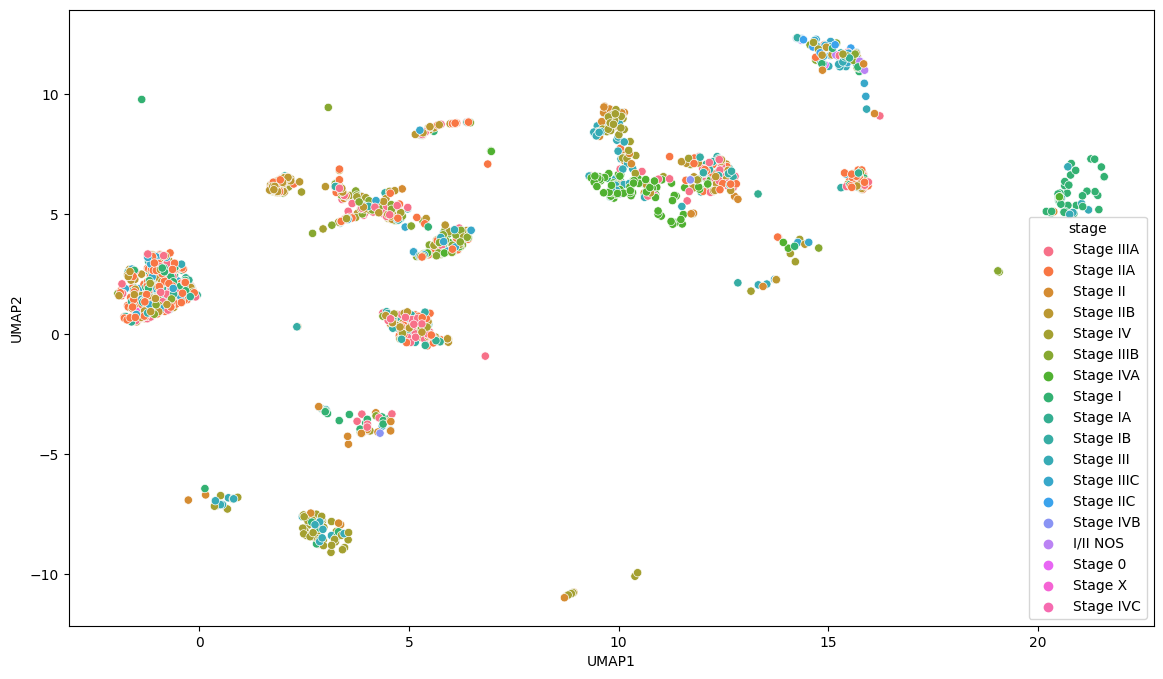

In [102]:
plt.figure(figsize=(14, 8))
sns.scatterplot(data=merged_latent_clinical_df, x="UMAP1", y="UMAP2", hue="stage")

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

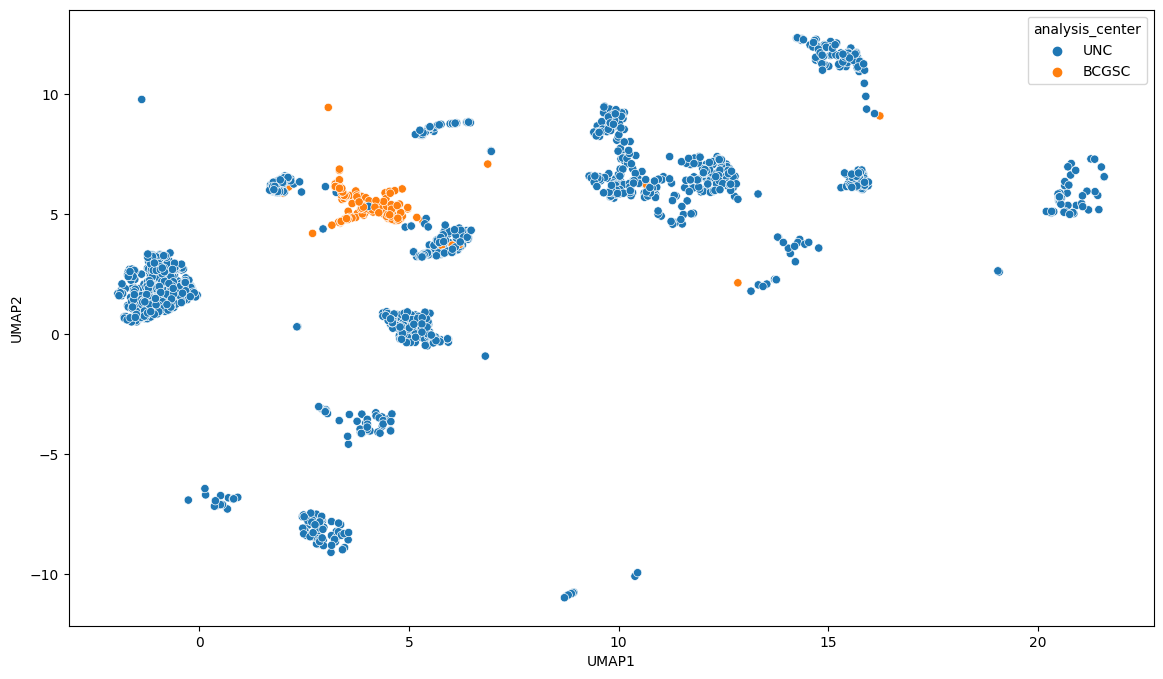

In [103]:
plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=merged_latent_clinical_df, x="UMAP1", y="UMAP2", hue="analysis_center"
)

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

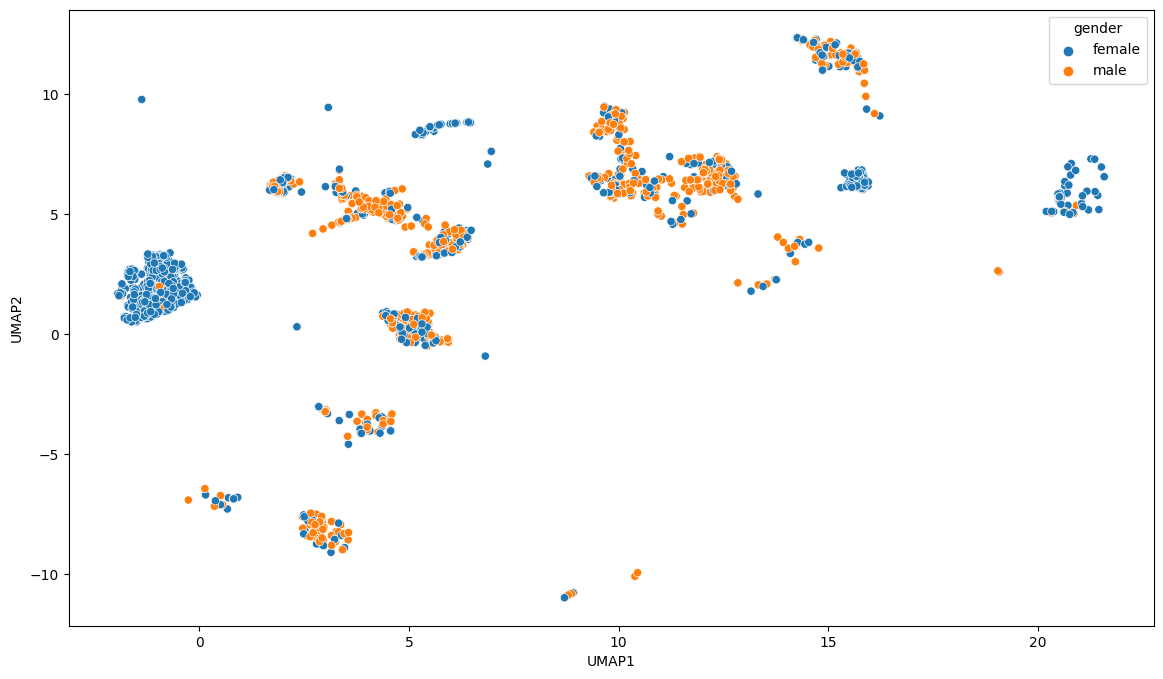

In [104]:
plt.figure(figsize=(14, 8))
sns.scatterplot(data=merged_latent_clinical_df, x="UMAP1", y="UMAP2", hue="gender")

In [80]:
# perform a multiclass classification

In [85]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split

# Assuming you have a pandas DataFrame named 'df' with features in 'features_column' and labels in 'label_column'

# Split the DataFrame into features (X) and labels (y)
merged_l_df = merged_latent_clinical_df.copy()
merged_l_df = merged_l_df.dropna()

merged_l_df["acronym"] = merged_l_df["acronym"].astype("category").cat.codes

X = merged_l_df[["UMAP1", "UMAP2"]]
y = merged_l_df["acronym"]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize and train the classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Compute roc_auc_score
auc_roc = roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_pred), average="macro")

# Compute F1-score
f1 = f1_score(y_test, y_pred, average="macro")

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)

# Compute classification report
classification_metrics = classification_report(y_test, y_pred)

# Print the AUC-ROC, F1-score, accuracy, and classification report
print("AUC-ROC:", auc_roc)
print("F1-score:", f1)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_metrics)

AUC-ROC: 0.658598549816573
F1-score: 0.788572019501961
Accuracy: 0.9134860050890585
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.86      0.88        21
           1       0.95      0.98      0.97       160
           2       0.75      0.95      0.84        19
           3       0.86      0.83      0.84        23
           4       0.00      0.00      0.00         1
           5       0.94      1.00      0.97        16
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         8
           8       0.82      0.97      0.89        29
           9       0.82      0.82      0.82        22
          10       0.95      0.91      0.93        22
          11       0.00      0.00      0.00         4
          12       0.94      0.68      0.79        22
          13       0.94      0.88      0.91        33
          14       1.00      1.00      1.00         9

    accuracy              

/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F

In [86]:
# Assuming you have a pandas DataFrame named 'df' with features in 'features_column' and labels in 'label_column'

# Split the DataFrame into features (X) and labels (y)
merged_l_df = merged_latent_clinical_df.copy()
merged_l_df = merged_l_df.dropna()

merged_l_df["organ"] = merged_l_df["organ"].astype("category").cat.codes

X = merged_l_df[["UMAP1", "UMAP2"]]
y = merged_l_df["organ"]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize and train the classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Compute roc_auc_score
auc_roc = roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_pred), average="macro")

# Compute F1-score
f1 = f1_score(y_test, y_pred, average="macro")

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)

# Compute classification report
classification_metrics = classification_report(y_test, y_pred)

# Print the AUC-ROC, F1-score, accuracy, and classification report
print("AUC-ROC:", auc_roc)
print("F1-score:", f1)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_metrics)

AUC-ROC: 0.9473980406008438
F1-score: 0.9196246653034634
Accuracy: 0.9338422391857506
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.81      0.83        21
           1       0.95      0.98      0.97       160
           2       0.96      0.96      0.96        23
           3       0.86      0.78      0.82        23
           4       1.00      0.95      0.98        22
           5       1.00      1.00      1.00         8
           6       0.86      0.98      0.92        51
           7       1.00      0.91      0.95        22
           8       0.94      0.73      0.82        22
           9       0.94      0.94      0.94        32
          10       1.00      0.89      0.94         9

    accuracy                           0.93       393
   macro avg       0.94      0.90      0.92       393
weighted avg       0.94      0.93      0.93       393



/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [55]:
# define functoins to add noise
# Define function to add gussian noise with different variance to each element of a pandas dataframe
def add_gaussian_noise(df, variances):
    assert len(variances) == len(
        df.columns
    ), "Number of variances must match the number of columns in the DataFrame."

    # Create a DataFrame with the same shape as the input DataFrame, filled with Gaussian random noise
    noise = pd.DataFrame(
        np.random.normal(0, np.sqrt(variances), size=df.shape), columns=df.columns
    )

    # Add the noise to the input DataFrame
    noisy_df = df + noise

    # Scale RNAseq data using zero-one normalization
    scaled_zeroone_df = preprocessing.MinMaxScaler().fit_transform(noisy_df)
    scaled_zeroone_df = pd.DataFrame(
        scaled_zeroone_df, columns=df.columns, index=df.index
    )

    return scaled_zeroone_df


# generate variances vector with a given upper values of maximum variance
def variance_vec(max_var, df):
    variances = np.linspace(0, max_var, len(df.columns))
    np.random.shuffle(variances)
    return variances

In [56]:
dataset_names_max_var = {
    "tcga_rnaseq_df_0p" + str(int(i * 100)): round(i, 2)
    for i in np.linspace(0.01, 0.9, 6)
}

In [57]:
# create a dictionary containing datasets with variable noises
noisy_datasets = {}
for i in dataset_names_max_var.keys():
    variance = variance_vec(dataset_names_max_var[i], rnaseq_df)
    noisy_datasets[i] = add_gaussian_noise(rnaseq_df, variance)

In [58]:
noisy_datasets.keys()

dict_keys(['tcga_rnaseq_df_0p1', 'tcga_rnaseq_df_0p18', 'tcga_rnaseq_df_0p36', 'tcga_rnaseq_df_0p54', 'tcga_rnaseq_df_0p72', 'tcga_rnaseq_df_0p90'])

Analysis with noisy data

In [61]:
latent_mu_0p90, latent_sigma_0p90 = VAE_latent_out(noisy_datasets['tcga_rnaseq_df_0p90'])

In [62]:
# Extract the features from the DataFrame
features_0p90 = latent_muf_0p90.iloc[:, 0:-1].values

# Perform UMAP dimensionality reduction
umap_result_0p90 = umap.UMAP().fit_transform(features_0p90)

# Create a new DataFrame with UMAP coordinates
umap_df_0p90 = pd.DataFrame(umap_result_0p90, columns=["UMAP1", "UMAP2"])

# Concatenate the UMAP DataFrame with the original DataFrame
result_df_0p90 = pd.concat([latent_mu_0p90, umap_df_0p90], axis=1)

In [64]:
embedded_dataframe_0p90 = result_df_0p90.copy()

In [65]:
embedded_dataframe_0p90["id"] = df["Unnamed: 0"]

In [67]:
merged_latent_clinical_df_0p90 = pd.merge(
    clincal_df, embedded_dataframe_0p90, on="id", how="inner"
)

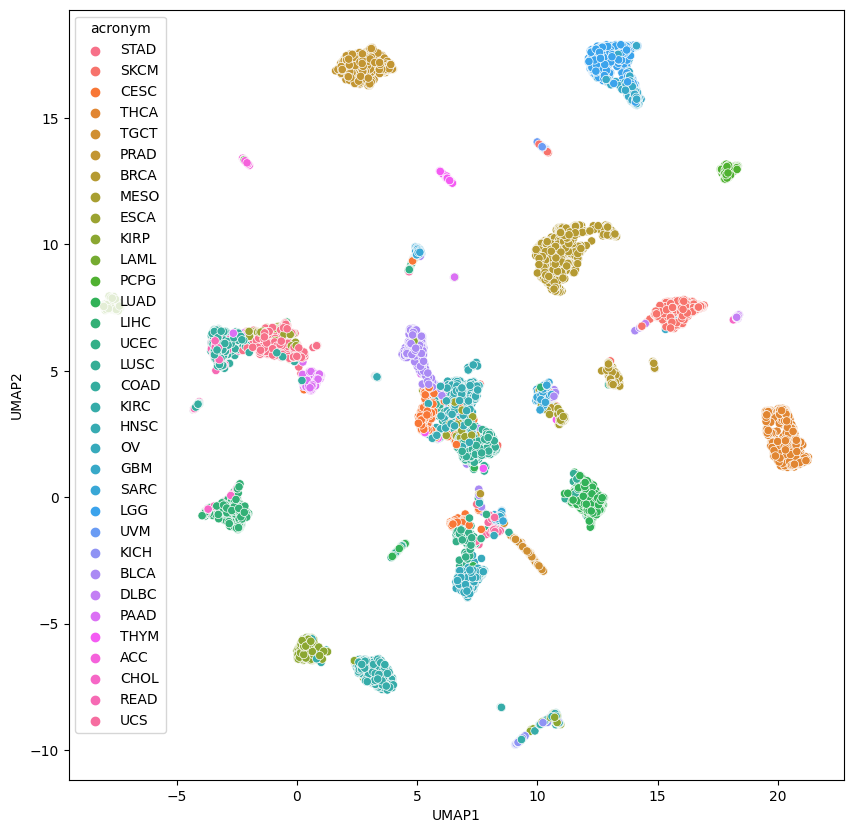

In [88]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=merged_latent_clinical_df, x="UMAP1", y="UMAP2", hue="acronym")
plt.savefig("../../Desktop/embedded.png")

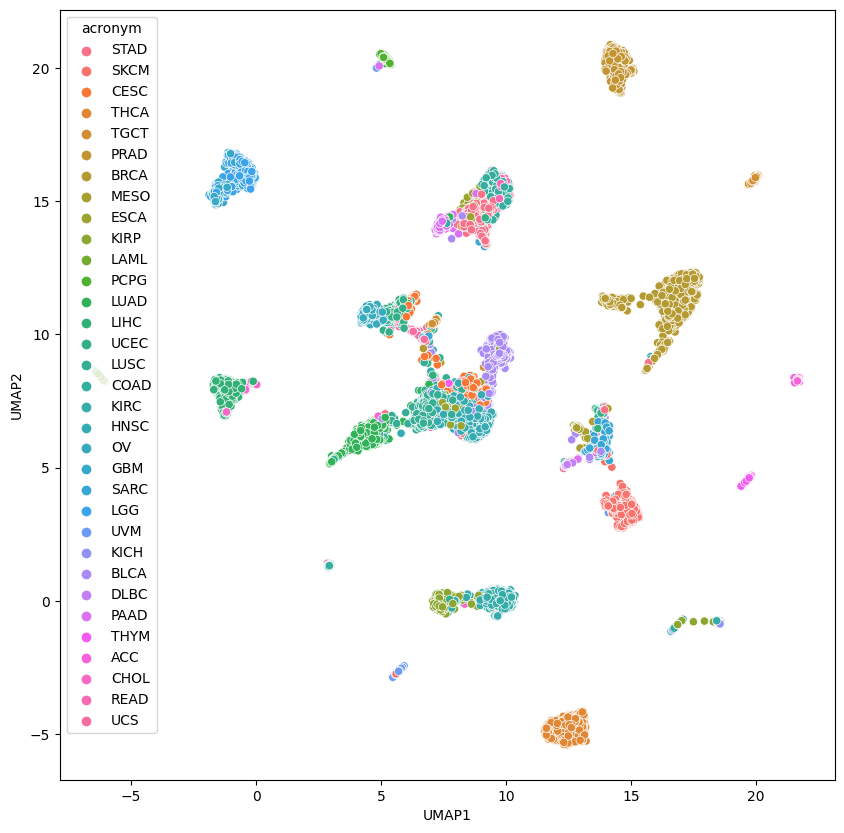

In [89]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=merged_latent_clinical_df_0p90, x="UMAP1", y="UMAP2", hue="acronym")
plt.savefig("../../Desktop/embedded_0p9.png")

In [91]:
# Assuming you have a pandas DataFrame named 'df' with features in 'features_column' and labels in 'label_column'

# Split the DataFrame into features (X) and labels (y)
merged_l_df = merged_latent_clinical_df.copy()
merged_l_df = merged_l_df.dropna()

merged_l_df["acronym"] = merged_l_df["acronym"].astype("category").cat.codes

X = merged_l_df[["UMAP1", "UMAP2"]]
y = merged_l_df["acronym"]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize and train the classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Compute roc_auc_score
auc_roc = roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_pred), average="macro")

# Compute F1-score
f1 = f1_score(y_test, y_pred, average="macro")

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)

# Compute classification report
classification_metrics = classification_report(y_test, y_pred)

# Print the AUC-ROC, F1-score, accuracy, and classification report
print("AUC-ROC:", auc_roc)
print("F1-score:", f1)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_metrics)

AUC-ROC: 0.658598549816573
F1-score: 0.788572019501961
Accuracy: 0.9134860050890585
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.86      0.88        21
           1       0.95      0.98      0.97       160
           2       0.75      0.95      0.84        19
           3       0.86      0.83      0.84        23
           4       0.00      0.00      0.00         1
           5       0.94      1.00      0.97        16
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         8
           8       0.82      0.97      0.89        29
           9       0.82      0.82      0.82        22
          10       0.95      0.91      0.93        22
          11       0.00      0.00      0.00         4
          12       0.94      0.68      0.79        22
          13       0.94      0.88      0.91        33
          14       1.00      1.00      1.00         9

    accuracy              

/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F

In [90]:
# Assuming you have a pandas DataFrame named 'df' with features in 'features_column' and labels in 'label_column'

# Split the DataFrame into features (X) and labels (y)
merged_l_df = merged_latent_clinical_df_0p90.copy()
merged_l_df = merged_l_df.dropna()

merged_l_df["acronym"] = merged_l_df["acronym"].astype("category").cat.codes

X = merged_l_df[["UMAP1", "UMAP2"]]
y = merged_l_df["acronym"]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize and train the classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Compute roc_auc_score
auc_roc = roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_pred), average="macro")

# Compute F1-score
f1 = f1_score(y_test, y_pred, average="macro")

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)

# Compute classification report
classification_metrics = classification_report(y_test, y_pred)

# Print the AUC-ROC, F1-score, accuracy, and classification report
print("AUC-ROC:", auc_roc)
print("F1-score:", f1)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_metrics)

AUC-ROC: 0.5489426253345226
F1-score: 0.7015648122816506
Accuracy: 0.8549618320610687
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.71      0.79        21
           1       0.98      0.96      0.97       160
           2       0.00      0.00      0.00        19
           3       0.66      0.83      0.73        23
           4       1.00      1.00      1.00         1
           5       0.80      1.00      0.89        16
           6       0.00      0.00      0.00         4
           7       1.00      1.00      1.00         8
           8       0.85      0.97      0.90        29
           9       0.80      0.73      0.76        22
          10       0.95      0.91      0.93        22
          11       0.00      0.00      0.00         4
          12       0.91      0.95      0.93        22
          13       0.54      0.88      0.67        33
          14       0.90      1.00      0.95         9

    accuracy            

/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F